In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from zStudy_WD import VAE, _dataset, compare_integer, compare_continuous
from os.path import join, basename, exists
from os import getcwd

In [2]:
# For saving img
dir_name = basename(getcwd())
img_dir = join(getcwd(), "images")
if not exists(img_dir):
    os.mkdir(img_dir)
variante= 'WD'
dir_name

'z_study'

In [3]:
from math import log10, floor
def round_sig(x, sig=2):
    # rounds to significant digits
   return round(x, sig-int(floor(log10(abs(x))))-1)

## Loading the Study

In [4]:
import gc

#Load bkg data
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
#bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)

# Get bkg shapes etc
bkg_shape = bkg.shape
bkg_columns = bkg.columns
bkg = bkg.to_numpy(dtype=np.float32)
bkg_weights = bkg_weights.to_numpy(dtype=np.float16)

# Get database names
import sqlite3
con = sqlite3.connect("optimization.db")
cursor = con.cursor()

cursor.execute("SELECT * FROM studies")
names = [x[1] for x in cursor.fetchall() if variante in x[1]]
names = sorted(names, key=lambda x: int(x.split("-")[1].replace(' zdim ', '').replace(' ', '')))
del con, cursor
gc.collect()
# Define variablers
x_axis = []
r2 = []
wd = []
means = []
stds = []
correlations = []


## Get data

In [5]:
for i,name in tqdm(enumerate(names), total=len(names)):
    zdim = int(name.split("-")[1].replace(' zdim ', '').replace(' ', ''))
    #print("Zdim:", zdim)

    study = optuna.load_study(study_name=name, storage="sqlite:///optimization.db")
    
    trial = study.best_trial
    

    # load model
    model = VAE.load_from_checkpoint(
        join('models', f"{variante.lower()}_zStudy-zdim_{zdim}_trial_{trial.number}.ckpt"),
        trial = optuna.trial.FixedTrial(trial.params), 
        zdim = zdim,
        dataset = "bkg", 
        batch_size=512)

    model.eval()
    

    ## Sample from the model
    # Random sample from N(0,1)
    sample = model.decode(torch.rand(bkg_shape[0], zdim)).detach().numpy()

    # Calculate WD Score
    objective_score = 0
    for idx in range(bkg_shape[1]):
        feature = bkg_columns[idx]
        if "Tag" in feature or "Multi" in feature:
            #print("Feature", feature, "é inteiro")
            objective_score += compare_integer(bkg[:, idx], bkg_weights, sample[:, idx], np.ones(bkg_weights.shape))
        else:
            #print("Feature", feature, "é continuo")
            objective_score += compare_continuous(bkg[:, idx], bkg_weights, sample[:, idx], np.ones(bkg_weights.shape))

    del sample, study, trial
    gc.collect()

    #print("R2")
    # Calculate R2 Score
    x_out, hidden = model.test_step(torch.from_numpy(bkg))
    hidden = hidden.detach().numpy()
    x_out = x_out.detach().numpy()
    r2_score_ = r2_score(bkg, x_out, sample_weight=bkg_weights)
    del x_out
    gc.collect()

    #print("Hidden")
    # Calculate hidden mean
    total_mean = []
    total_std = []
    for x in range(hidden.shape[1]):
        total_mean.append(hidden[:, x].mean())
        total_std.append(hidden[:, x].std())
    mean = np.array(total_mean).mean()
    std = np.array(total_std).mean()

    # Correlations
    corr = pd.DataFrame(hidden).corr().apply(abs)
    corr.replace(1, 0, inplace=True)
    correlations.append(round(corr.mean().mean(), 5))
    
    
    # Storing values
    means.append(round(abs(mean),6))
    stds.append(round(std,6))
    x_axis.append(zdim)
    wd.append(round(objective_score,6))
    r2.append(round(r2_score_,6))

    del hidden, model, mean, std
    gc.collect()

num_trials = []
for i,name in tqdm(enumerate(names), total=len(names)):
    zdim = int(name.split("-")[1].replace(' zdim ', '').replace(' ', ''))

    study = optuna.load_study(study_name=name, storage="sqlite:///optimization.db")
    num_trials.append(len(study.trials))


In [6]:
del bkg, bkg_columns, bkg_shape, bkg_weights
gc.collect()

bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
signal = _dataset(category='all',variant='signal').all_data()

data = pd.concat([signal, bkg])
del signal, bkg

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score

rocs = {}

features = list(data['name'].unique())
distributions = {}

for i,name in tqdm(enumerate(names), total=len(names)):
    zdim = int(name.split("-")[1].replace(' zdim ', '').replace(' ', ''))

    study = optuna.load_study(study_name=name, storage="sqlite:///optimization.db")
    trial = study.best_trial
    model = VAE.load_from_checkpoint(
        join('models', f"{variante.lower()}_zStudy-zdim_{zdim}_trial_{trial.number}.ckpt"),
        trial = optuna.trial.FixedTrial(trial.params), 
        zdim = zdim,
        dataset = "bkg", 
        batch_size=512)

    model.eval()

    for x in features:

        ## Get the relevant data
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        ## Pass input through model to get the output
        output, _ = model.test_step(sData)

        ## Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        gc.collect()
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    del model, trial, study, error_dist
    gc.collect()

    ## Normalize the distributions
    # This way all values should be between 0 and 1
    # x transform
    min_of_dist = min(map(lambda x: min(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] - min_of_dist
    # scale
    max_of_dist = max(map(lambda x: max(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    
    ## Plot ROC Curves
    #fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in distributions.keys():
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            # Set Scores
            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

            # Set weights
            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            name = x.replace('.h5', '')
            if name not in rocs.keys():
                rocs[name] = []

            rocs[name].append(roc_auc_score(y_true=labels, y_score=score,sample_weight=weights))

        
            #print("Confusion matrix:")
            #print(confusion_matrix(labels, np.rint(score)))

del distributions, weights
gc.collect()


5

## Plot data

<ipython-input-8-9c882a45c621>:18: UserWarning:

You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.

<ipython-input-8-9c882a45c621>:19: UserWarning:

You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.



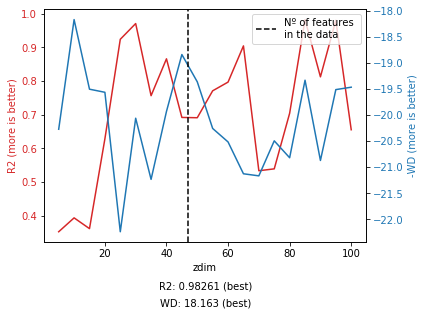

In [8]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('zdim')
ax1.set_ylabel('R2 (more is better)', color=color)
ax1.plot(x_axis, r2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('-WD (more is better)', color=color)  # we already handled the x-label with ax1
ax2.plot(x_axis, [-x for x in wd], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.annotate(f'R2: {str(round_sig(max(r2),5))} (best)', (0.5,-0.2), xycoords='axes fraction', textcoords='offset points', ha='center')
plt.annotate(f'WD: {str(round_sig(min(wd),5))} (best)', (0.5,-0.275), xycoords='axes fraction', textcoords='offset points', ha='center')
plt.axvline(47, ymin=0, ymax=1, color="black", linestyle='--', label="Nº of features \nin the data")
plt.legend(loc='best')
fig.savefig(join(img_dir, dir_name+variante+"_r2_wd.png"), bbox_inches = 'tight')
plt.show()

<ipython-input-9-75f643e9f0c8>:18: UserWarning:

You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.

<ipython-input-9-75f643e9f0c8>:19: UserWarning:

You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.



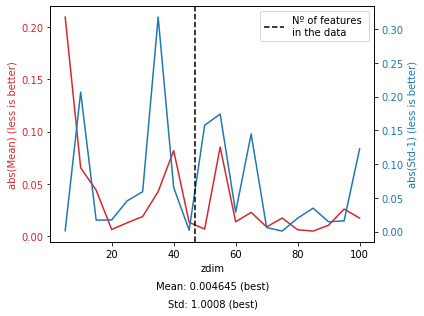

In [9]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('zdim')
ax1.set_ylabel('abs(Mean) (less is better)', color=color)
ax1.plot(x_axis, means, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('abs(Std-1) (less is better)', color=color)  # we already handled the x-label with ax1
ax2.plot(x_axis, [abs(x-1) for x in stds], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.annotate(f'Mean: {str(round_sig(min(means),5))} (best)', (0.5,-0.2), xycoords='axes fraction', textcoords='offset points', ha='center')
plt.annotate(f'Std: {str(round_sig(min(stds, key=lambda x:abs(x-1)),5))} (best)', (0.5,-0.275), xycoords='axes fraction', textcoords='offset points', ha='center')
plt.axvline(47, ymin=0, ymax=1, color="black", linestyle='--', label="Nº of features \nin the data")
plt.legend(loc='best')
fig.savefig(join(img_dir, dir_name+variante+"_mean_std.png"), bbox_inches = 'tight')
plt.show()

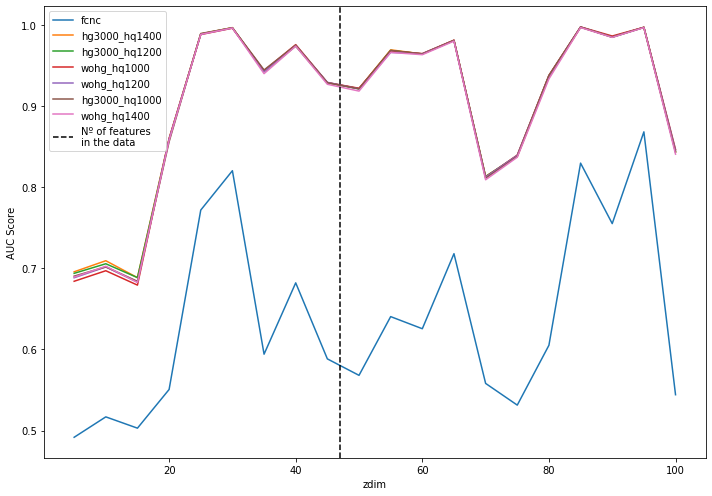

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
for key in rocs.keys():
    ax.set_xlabel('zdim')
    ax.set_ylabel('AUC Score')
    ax.plot(x_axis, rocs[key], label=key)
    #ax.plot([0,1],[0,1], 'k--')
    #ax.tick_params(axis='y', labelcolor=color)

plt.axvline(47, ymin=0, ymax=1, color="black", linestyle='--', label="Nº of features \nin the data")
plt.legend(loc='best')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig(join(img_dir, dir_name+variante+"_aucScores.png"), bbox_inches = 'tight')
plt.show()

## Sanity check

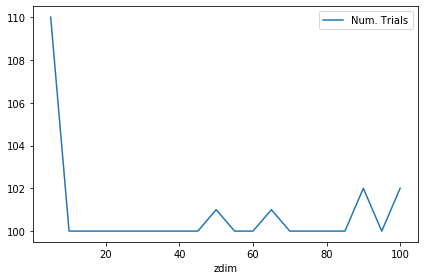

In [11]:
num_trials = []
for i,name in tqdm(enumerate(names), total=len(names)):
    zdim = int(name.split("-")[1].replace(' zdim ', '').replace(' ', ''))

    study = optuna.load_study(study_name=name, storage="sqlite:///optimization.db")
    num_trials.append(len(study.trials))
    
fig, ax = plt.subplots()

ax.set_xlabel('zdim')
ax.set_ylabel('')
ax.plot(x_axis, num_trials, label='Num. Trials')

ax.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()